# Computer Vision 2024 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

**Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

**Q1.2 (2 points)** 

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   |      |
|0.1|          |
|0.01|         |
|0.001  |        |


**Q1.3 (3 points)** 

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loss curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |      |     |
|0.1|          |    |
|0.01|         |    |
|0.001  |        |     |


**Q1.4 (2 points)** 

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?


**Q1.5 (5 points)** 

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the oroginal network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   |      ||
|Deeper|          ||
|Wider|         ||


**Q1.6 (2 points)** 

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.7, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

**Q1.7 (5 points)** 

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with rehgard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [1]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters). 

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [4]:
label_defs = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.  

### Question 1.1

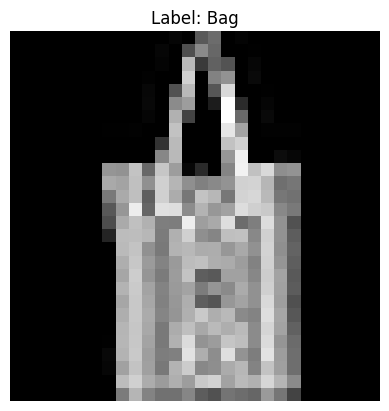

Shape: torch.Size([28, 28])




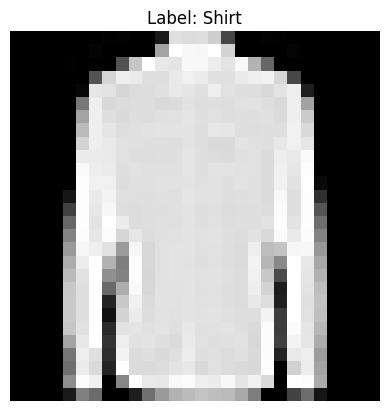

Shape: torch.Size([28, 28])




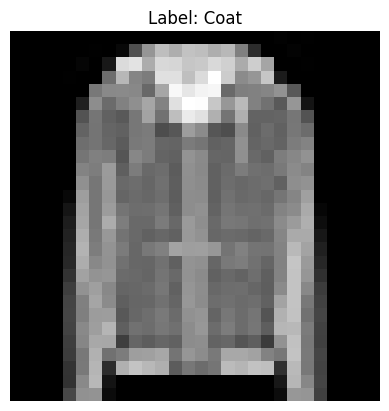

Shape: torch.Size([28, 28])




In [5]:
# Code cell for training image display
images, labels = next(iter(train_dataloader))

import random
training_indices = random.sample(range(batch_size), 3)

training_images = [(images[index][0,:,:], labels[index]) for index in training_indices]

for image in training_images:
    plt.imshow(image[0], cmap="gray")
    plt.title(f"Label: {label_defs[int(image[1])]}")
    plt.axis("off")
    plt.show()
    print(f"Shape: {image[0].shape}")
    print("\n")

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [8]:
def train(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = train_loss.item(), batch * len(X)
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return train_loss.item()

In [9]:
# Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

### Question 1.2

Training for 10 epochs with learning rate: 1
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.6%, Avg loss: 2.325459 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305836 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 16.0%, Avg loss: 2.168829 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 20.0%, Avg loss: 3.489796 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305837 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305836 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305832 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305843 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305843 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.305843 



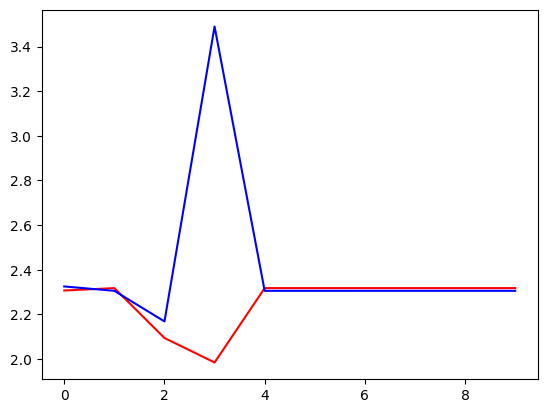

Done!

Training for 10 epochs with learning rate: 0.1
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.548591 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.468552 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.422756 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.409166 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.392113 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.376008 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.365362 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.355892 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.344796 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.343784 



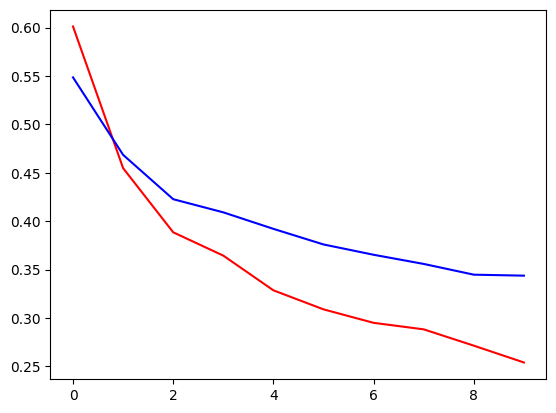

Done!

Training for 10 epochs with learning rate: 0.01
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 71.0%, Avg loss: 0.799084 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 77.9%, Avg loss: 0.636381 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 79.8%, Avg loss: 0.573668 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.542203 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.520829 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.505264 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 82.3%, Avg loss: 0.492061 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.481247 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.471502 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.461915 



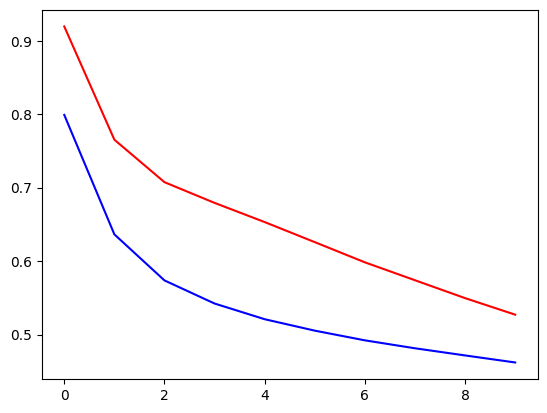

Done!

Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 45.7%, Avg loss: 2.147619 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.872733 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 62.3%, Avg loss: 1.504780 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 63.7%, Avg loss: 1.243046 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 64.7%, Avg loss: 1.081236 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 66.1%, Avg loss: 0.976525 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.904825 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.853037 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 69.9%, Avg loss: 0.813733 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.782497 



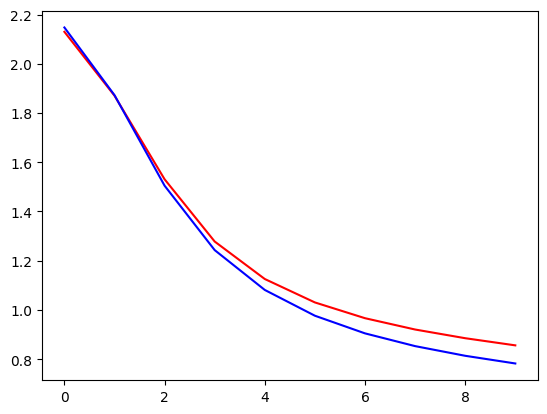

Done!

Lr       Accuracy  
1        10.0 %
0.1      87.47%
0.01     83.37%
0.001    71.46000000000001%


In [10]:
#Train and test the model
epochs = 10

learning_rates = [1, 1e-1, 1e-2, 1e-3]

learning_rate_accuracy = {1: 0, 1e-1: 0, 1e-2: 0, 1e-3: 0}

for rate in learning_rates:
    print(f"Training for {epochs} epochs with learning rate: {rate}")
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=rate)

    train_losses = []
    test_losses = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer, False)
        test_loss, accuracy = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

    learning_rate_accuracy[rate] = accuracy

    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(test_losses), 'b')
    plt.show()

    print("Done!\n")
    
print("{:<8} {:<10}".format('Lr','Accuracy'))
for rate, accuracy in learning_rate_accuracy.items():
    print("{:<8} {:<5}%".format(rate, accuracy * 100))

### Question 1.3

Training with learning rate: 1 until reaching 85% accuracy
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 31.1%, Avg loss: 1.634982 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 31.7%, Avg loss: 1.732914 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 19.8%, Avg loss: 1.780719 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.1%, Avg loss: 1.733612 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.723234 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.718504 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 20.0%, Avg loss: 1.717508 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 19.9%, Avg loss: 1.709712 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 20.0%, Avg loss: 1.737512 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 28.7%, Avg loss: 1.639009 

Epoch 11
-----------

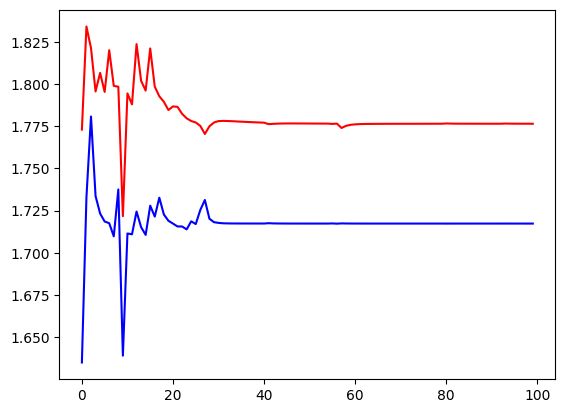

Got accuracy 19.9% in 100 epochs
Training with learning rate: 0.1 until reaching 85% accuracy
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.549380 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.488078 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.432620 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.406970 



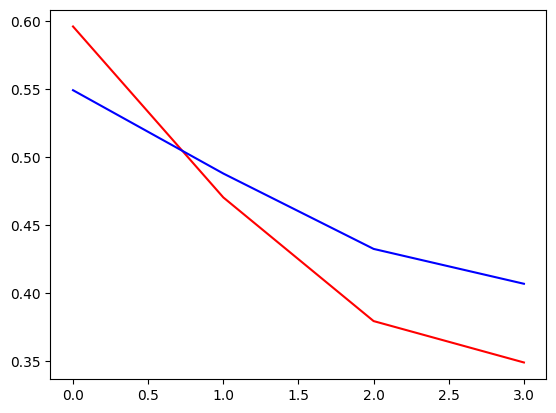

Got accuracy 85.0% in 4 epochs
Training with learning rate: 0.01 until reaching 85% accuracy
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.786560 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.628442 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.564828 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.534048 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.514789 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.499682 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.488341 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.478040 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.468833 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 83.4%, Avg los

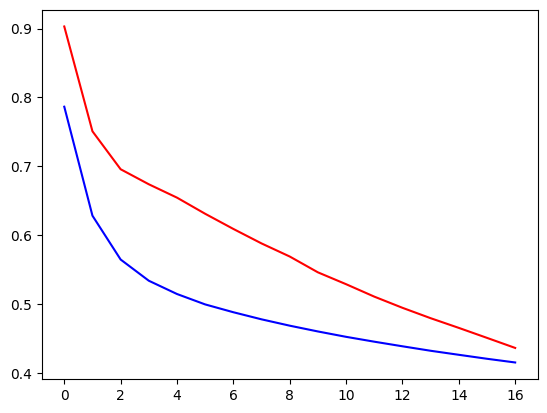

Got accuracy 85.1% in 17 epochs
Training with learning rate: 0.001 until reaching 85% accuracy
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 44.6%, Avg loss: 2.158727 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.884165 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 60.1%, Avg loss: 1.518632 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 63.1%, Avg loss: 1.256925 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 64.5%, Avg loss: 1.092697 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 65.5%, Avg loss: 0.985632 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.912364 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.859665 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.820010 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 70.2%, Avg l

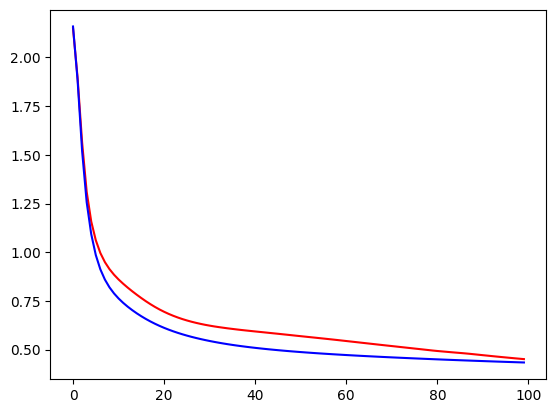

Got accuracy 84.4% in 100 epochs
Lr       Accuracy   Epoch
1        19.869999999999997% 100  
0.1      85.0 % 4    
0.01     85.11% 17   
0.001    84.41% 100  


In [13]:
# Train and test the model
learning_rates = [1, 1e-1, 1e-2, 1e-3]

learning_rate_accuracy = {1: 0, 1e-1: 0, 1e-2: 0, 1e-3: 0}
learning_rate_epochs = {1: 0, 1e-1: 0, 1e-2: 0, 1e-3: 0}

for rate in learning_rates:
    print(f"Training with learning rate: {rate} until reaching 85% accuracy")
    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=rate)

    train_losses = []
    test_losses = []

    epoch = 0
    while True:
        print(f"Epoch {epoch+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer, False)
        test_loss, accuracy = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if accuracy >= 0.85 or epoch >= 99:
            break
        
        epoch += 1
        
    learning_rate_accuracy[rate] = accuracy
    learning_rate_epochs[rate] = epoch + 1

    plt.plot(np.array(train_losses), 'r')
    plt.plot(np.array(test_losses), 'b')
    plt.show()

    print(f"Got accuracy {(100*accuracy):>0.1f}% in {epoch + 1} epochs")
    
print("{:<8} {:<10} {:<5}".format('Lr','Accuracy', 'Epoch'))
for rate in learning_rates:
    accuracy = learning_rate_accuracy[rate]
    epoch = learning_rate_epochs[rate]
    print("{:<8} {:<5}% {:<5}".format(rate, accuracy * 100, epoch))

After some investigation, it woas found that for a learning rate of 1, the accuracy was not able to increase to
reach 85%. This can be seen in thee above running of code, where a limit of 100 epochs was chosen and if the accuracy
had not reached 85% by this time, then the attempt was abandoned and the accuracy achieved was included in the table as
it was found after 100 epochs. This may be the case because the learning rate was too high for the data, and the model
is not able to converge. This can be seen in the outputs above for the learning rate of 1, where the loss does not
reduce as the model is trained further.

### Question 1.4

In comparing the results of the tables generated in Question 1.2 and Question 1.3, it is clear that as the learning rate
decreases, the number of epochs required to reach a higher accuracy increases. However, with very high training rates,
in this case, a training rate of 1, the model does not converge and the training loss does not reduce with more training
of the model. The other training rates are able to successfully achieve an accuracy of over 85%, with the training with
a higher learning rate able to achieve this in less epochs than when training at a lower learning rate. This indicates
that the number of epochs to achieve a given accuracy and the learning rate are inversely proportional.

### Question 1.5

#### Base model

In [14]:
def get_num_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = {"base": 0, "wider": 0, "deeper": 0}
accuracies =  {"base": 0, "wider": 0, "deeper": 0}

Using cuda device
BaseNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.284023  [    0/60000]
loss: 2.290835  [ 6400/60000]
loss: 2.265380  [12800/60000]
loss: 2.270940  [19200/60000]
loss: 2.243598  [25600/60000]
loss: 2.206037  [32000/60000]
loss: 2.221762  [38400/60000]
loss: 2.181980  [44800/60000]
loss: 2.179144  [51200/60000]
loss: 2.147452  [57600/60000]
Test Error: 
 Accuracy: 40.1%, Avg loss: 2.142791 

Epoch 2
-------------------------------
loss: 2.149441  [    0/60000]
loss: 2.148928  [ 6400/60000]
loss: 2.080436  [12800/60000]
loss: 2.106400  [19200/60000]
loss: 2.039692  [25600/60000]
loss: 1.974602  [32000/60000

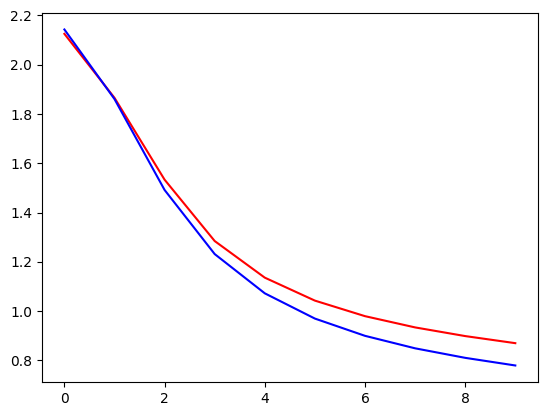

Model accuracy is: 0.715
Model has 669706 parameters


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class BaseNeuralNetwork(nn.Module):
    def __init__(self):
        super(BaseNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

num_params["base"] = get_num_parameters(model)
model = BaseNeuralNetwork().to(device)
print(model)

#Train and test the model
epochs = 10
rate = 1e-3

print(f"Training for {epochs} epochs with learning rate: {rate}")
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

accuracies["base"] = accuracy
print(f"Model accuracy is: {accuracies['base']}")
print(f"Model has {num_params['base']} parameters")

#### Wider model

Using cuda device
WiderNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.294228  [    0/60000]
loss: 2.282108  [ 6400/60000]
loss: 2.250143  [12800/60000]
loss: 2.246608  [19200/60000]
loss: 2.225414  [25600/60000]
loss: 2.173778  [32000/60000]
loss: 2.183649  [38400/60000]
loss: 2.134665  [44800/60000]
loss: 2.140521  [51200/60000]
loss: 2.086738  [57600/60000]
Test Error: 
 Accuracy: 50.7%, Avg loss: 2.084289 

Epoch 2
-------------------------------
loss: 2.098476  [    0/60000]
loss: 2.086004  [ 6400/60000]
loss: 2.005016  [12800/60000]
loss: 2.032051  [19200/60000]
loss: 1.948710  [25600/60000]
loss: 1.881223  [32000/

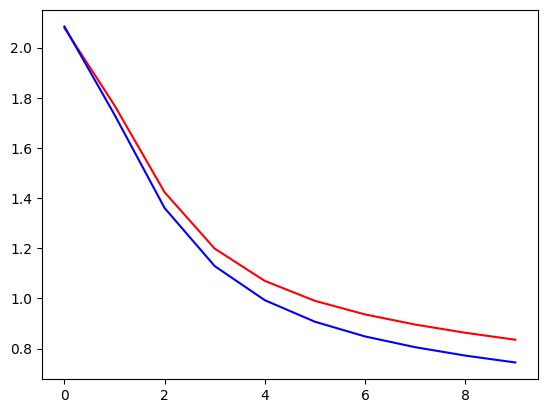

Model accuracy is: 0.7323
Model has 1863690 parameters


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class WiderNeuralNetwork(nn.Module):
    def __init__(self):
        super(WiderNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = WiderNeuralNetwork().to(device)
num_params["wider"] = get_num_parameters(model)
print(model)

#Train and test the model
epochs = 10
rate = 1e-3

print(f"Training for {epochs} epochs with learning rate: {rate}")
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

accuracies["wider"] = accuracy
print(f"Model accuracy is: {accuracies['wider']}")
print(f"Model has {num_params['wider']} parameters")

#### Deeper model

Using cuda device
DeeperNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=10, bias=True)
  )
)
Training for 10 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.308864  [    0/60000]
loss: 2.305411  [ 6400/60000]
loss: 2.304214  [12800/60000]
loss: 2.298974  [19200/60000]
loss: 2.305872  [25600/60000]
loss: 2.302269  [32000/60000]
loss: 2.297973  [38400/60000]
loss: 2.301029  [44800/60000]
loss: 2.302034  [51200/60000]
loss: 2.294982  [57600/60000]
Test Error: 
 Accuracy: 10.9%, Avg loss: 2.298675 

Epoch 2
-------------------------------
loss: 2.303227  [   

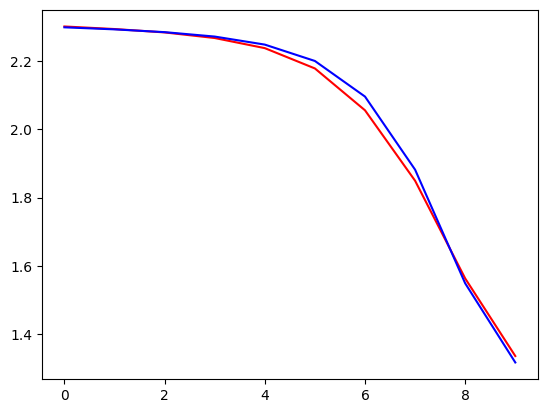

Model accuracy is: 0.497
Model has 1195018 parameters


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = DeeperNeuralNetwork().to(device)
num_params["deeper"] = get_num_parameters(model)
print(model)

#Train and test the model
epochs = 10
rate = 1e-3

print(f"Training for {epochs} epochs with learning rate: {rate}")
###Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

accuracies["deeper"] = accuracy
print(f"Model accuracy is: {accuracies['deeper']}")
print(f"Model has {num_params['deeper']} parameters")

In [18]:
print("{:<10} {:<10} {:<10}".format('Structures','Accuracy', 'Parameters'))
for structure in ["base", "wider", "deeper"]:
    accuracy = accuracies[structure]
    parameters = num_params[structure]
    print("{:<10} {:<10}% {:<10}".format(structure, accuracy * 100, parameters))

Structures Accuracy   Parameters
base       71.5      % 669706    
wider      73.22999999999999% 1863690   
deeper     49.7      % 1195018   


From the results above, the wider network structure was able to achieve a slightly better accuracy than the base model,
but the deeper model actually had an accuracy reduction. It is possible that the network needs more training as it now
has more parameters, and this should be tested to see if that is the case. We can test training the same deeper model
but with more epochs to see if the accuracy improves.

#### Deeper model with more epochs

Training for 50 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.306122  [    0/60000]
loss: 2.302324  [ 6400/60000]
loss: 2.298337  [12800/60000]
loss: 2.298876  [19200/60000]
loss: 2.298498  [25600/60000]
loss: 2.297678  [32000/60000]
loss: 2.302513  [38400/60000]
loss: 2.299364  [44800/60000]
loss: 2.301500  [51200/60000]
loss: 2.297606  [57600/60000]
Test Error: 
 Accuracy: 14.5%, Avg loss: 2.296031 

Epoch 2
-------------------------------
loss: 2.299687  [    0/60000]
loss: 2.296878  [ 6400/60000]
loss: 2.291625  [12800/60000]
loss: 2.293523  [19200/60000]
loss: 2.292868  [25600/60000]
loss: 2.290528  [32000/60000]
loss: 2.296480  [38400/60000]
loss: 2.292460  [44800/60000]
loss: 2.294390  [51200/60000]
loss: 2.290358  [57600/60000]
Test Error: 
 Accuracy: 22.5%, Avg loss: 2.288619 

Epoch 3
-------------------------------
loss: 2.292092  [    0/60000]
loss: 2.290196  [ 6400/60000]
loss: 2.283271  [12800/60000]
loss: 2.286692  [19200/60000]
loss: 2

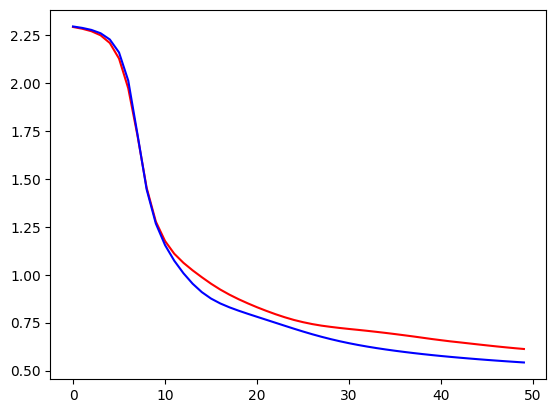

Deeper model accuracy is: 0.8062
Training for 50 epochs with learning rate: 0.001
Epoch 1
-------------------------------
loss: 2.303873  [    0/60000]
loss: 2.292670  [ 6400/60000]
loss: 2.281146  [12800/60000]
loss: 2.271633  [19200/60000]
loss: 2.256431  [25600/60000]
loss: 2.224319  [32000/60000]
loss: 2.234491  [38400/60000]
loss: 2.198293  [44800/60000]
loss: 2.193406  [51200/60000]
loss: 2.169432  [57600/60000]
Test Error: 
 Accuracy: 46.5%, Avg loss: 2.163906 

Epoch 2
-------------------------------
loss: 2.171407  [    0/60000]
loss: 2.161674  [ 6400/60000]
loss: 2.115687  [12800/60000]
loss: 2.130499  [19200/60000]
loss: 2.078270  [25600/60000]
loss: 2.022399  [32000/60000]
loss: 2.050585  [38400/60000]
loss: 1.973611  [44800/60000]
loss: 1.977142  [51200/60000]
loss: 1.915118  [57600/60000]
Test Error: 
 Accuracy: 59.2%, Avg loss: 1.910656 

Epoch 3
-------------------------------
loss: 1.940034  [    0/60000]
loss: 1.907181  [ 6400/60000]
loss: 1.806028  [12800/60000]
loss

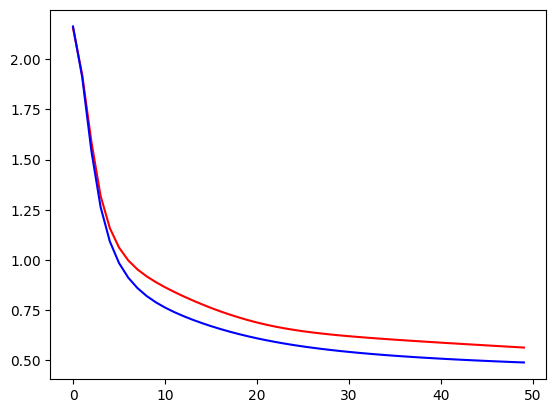

Base model accuracy is: 0.8275


In [19]:
#Train and test the model
epochs = 50
rate = 1e-3

# Train deeper model for more epochs
print(f"Training for {epochs} epochs with learning rate: {rate}")
model = DeeperNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

print(f"Deeper model accuracy is: {accuracy}")

# Train base model for more epochs
print(f"Training for {epochs} epochs with learning rate: {rate}")
model = BaseNeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

train_losses = []
test_losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

# TODO: Add legent for losses

plt.plot(np.array(train_losses), 'r')
plt.plot(np.array(test_losses), 'b')
plt.show()

print(f"Base model accuracy is: {accuracy}")

After incresasing the number of epochs used to train the model, it can be seen that the accuracy for the deeper model
has continued to increase and the loss was able to continue decreasing as more epochs were trained. From the above
graphs comparing the loss as the deeper model and the base model are trained, it seems that the loss of the deeper model
can continue to decrease, while the loss of the base model has flattened out. This may indicate that the deeper model
can be trained further to continue improving the accuracy, while the base model is not able to be trained further.

### Question 1.6

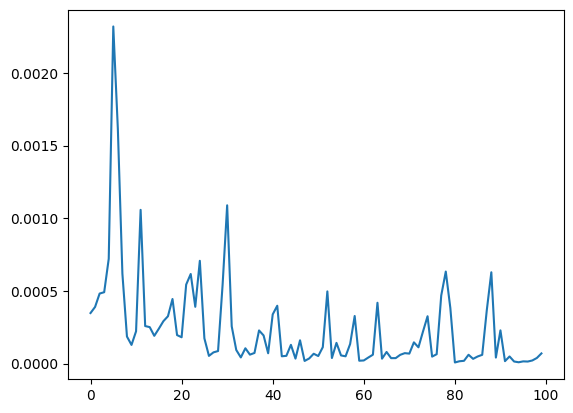

In [20]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

mean_gradients = []

model = NeuralNetwork().to(device)

rate = 1
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=rate)

epochs = 10
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        train_loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        
        if model.linear_relu_stack[0].weight.grad is not None:
            mean_grad = model.linear_relu_stack[0].weight.grad.abs().mean().item()
            mean_gradients.append(mean_grad)

        if len(mean_gradients) >= 100:
            break

        optimizer.step()

        if batch % 100 == 0:
            loss, current = train_loss.item(), batch * len(X)

    if len(mean_gradients) >= 100:
        break

plt.plot(np.array(mean_gradients))
plt.show()

As shown above, the mean of the gradients of loss has been calculated for the first 100 steps in the training. This has
then been plotted on a graph. It can be seen in the graph that over the training for the first 100 steps, the gradients
curve decreases.

### Question 1.7

In [45]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.requires_grad_()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = correct / total
print(f'Accuracy of the network on the test images: {100 * cnn_accuracy} %')

Finished Training
Accuracy of the network on the test images: 87.29 %


In [46]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in label_defs.values()}
total_pred = {classname: 0 for classname in label_defs.values()}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label_defs[int(label)]] += 1
            total_pred[label_defs[int(label)]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: T-shirt/top is 81.7 %
Accuracy for class: Trouser is 98.2 %
Accuracy for class: Pullover is 60.9 %
Accuracy for class: Dress is 88.5 %
Accuracy for class: Coat  is 84.5 %
Accuracy for class: Sandal is 96.3 %
Accuracy for class: Shirt is 73.0 %
Accuracy for class: Sneaker is 96.6 %
Accuracy for class: Bag   is 97.5 %
Accuracy for class: Ankle boot is 95.7 %


In [47]:
num_cnn_params = get_num_parameters(net)

accuracies["cnn"] = cnn_accuracy
num_params["cnn"] = num_cnn_params

structures = {"base": "Base MLP", "wider": "Wider MLP", "deeper": "Deeper MLP", "cnn": "CNN"}

print("{:<10} {:<10} {:<10}".format('Structures','Accuracy', 'Parameters'))
for structure in structures:
    accuracy = accuracies[structure]
    parameters = num_params[structure]
    print("{:<10} {:<10}% {:<10}".format(structures[structure], accuracy * 100, parameters))

Structures Accuracy   Parameters
Base MLP   71.5      % 669706    
Wider MLP  73.22999999999999% 1863690   
Deeper MLP 49.7      % 1195018   
CNN        87.29     % 46982     


From the results above, the convolutional neural network was able to achieve results with better accuracy to the MLP
that was trained with the same learning rate. A result of 87% accuracy as able to be achieved with the CNN compared to
only 72% for the base MLP, 73% for the wider MLP and 50% for the deeper MLP when training for just 10 epochs.

Because of this, it is clear that the CNN is able to converge in less epochs than the MLP model, achieving a higher
accuracy with less training time. When comparing the number of parameters across models, it is also clear that this CNN
has far less parameters, than any of the MLP models tested. With less than one tenth the number of parameters in the
base MLP, and an even smaller percentage of the number of parameters in the wider or deeper MLPs tested.

We can also see that the accuracies found for classifying the images into classes was very high for the CNN model, often
approaching 100%, especially for the trousers, sneakers, sandals, bag, and ankle boot. But the accuracy for the pullover
was quite low in comparison, only 61%. This may indicate that more training is needed for that particular class of image
or that there are less features available in pullover images to effectively match on.

Given this, it is likely that a CNN is a better method to classify these images compared to using a MLP to do the same
task.